In [1]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Most general form of cross-validation, with history
---

This provides little personalization, and still avoids the issue of using a subject's future data for prediction.

In [2]:
from os import path
import sys

import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_predict

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = path.join("..", 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
%aimport models.fit_predict
%aimport visualization.visualize
from features.build_features import previous_value
from models.fit_predict import cv_predict
from visualization.visualize import modified_bland_altman_plot

In [3]:
file = path.join("..", "data", "interim", "df.csv")
df = pd.read_csv(file, index_col=0)

## Compute features

In [4]:
NUMBER_OF_DAYS = 10
df = df[df.L_PREOVULATION > NUMBER_OF_DAYS]  # No use predicting backward in time.
temp_measurements = ["TEMP" + str(i + 1) for i in range(NUMBER_OF_DAYS)]
features = [*temp_measurements,"past_L_CYCLE", "past_L_PREOVULATION"]

In [5]:
df['past_L_PREOVULATION'] = previous_value('L_PREOVULATION', df)
df['past_L_CYCLE'] = previous_value('L_CYCLE', df)

df.dropna(subset=[
    'past_L_PREOVULATION', 
    'past_L_CYCLE'
], inplace=True)

features += ['past_L_PREOVULATION', 'past_L_CYCLE']

### $n$ days of temperature measurements.

The use case requires deleting those whose ovulation occurs before these $n$ days.

In [6]:
NUMBER_OF_DAYS = 10
df = df[df.L_PREOVULATION > NUMBER_OF_DAYS]  # No use predicting backward in time.
temp_measurements = ["TEMP" + str(i + 1) for i in range(NUMBER_OF_DAYS)]
features += temp_measurements

In [7]:
features

['TEMP1',
 'TEMP2',
 'TEMP3',
 'TEMP4',
 'TEMP5',
 'TEMP6',
 'TEMP7',
 'TEMP8',
 'TEMP9',
 'TEMP10',
 'past_L_CYCLE',
 'past_L_PREOVULATION',
 'past_L_PREOVULATION',
 'past_L_CYCLE',
 'TEMP1',
 'TEMP2',
 'TEMP3',
 'TEMP4',
 'TEMP5',
 'TEMP6',
 'TEMP7',
 'TEMP8',
 'TEMP9',
 'TEMP10']

In [8]:
X = df[features]
y = df.L_PREOVULATION
grouping = df.ID

## Perform regression

In [9]:
y_pred = cv_predict(X, y, grouping)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.9s finished


In [10]:
mean_squared_error(y_pred=y_pred, y_true=y)

12.367897865295834

In [11]:
mean_absolute_error(y_pred=y_pred, y_true=y)

2.393288807628096

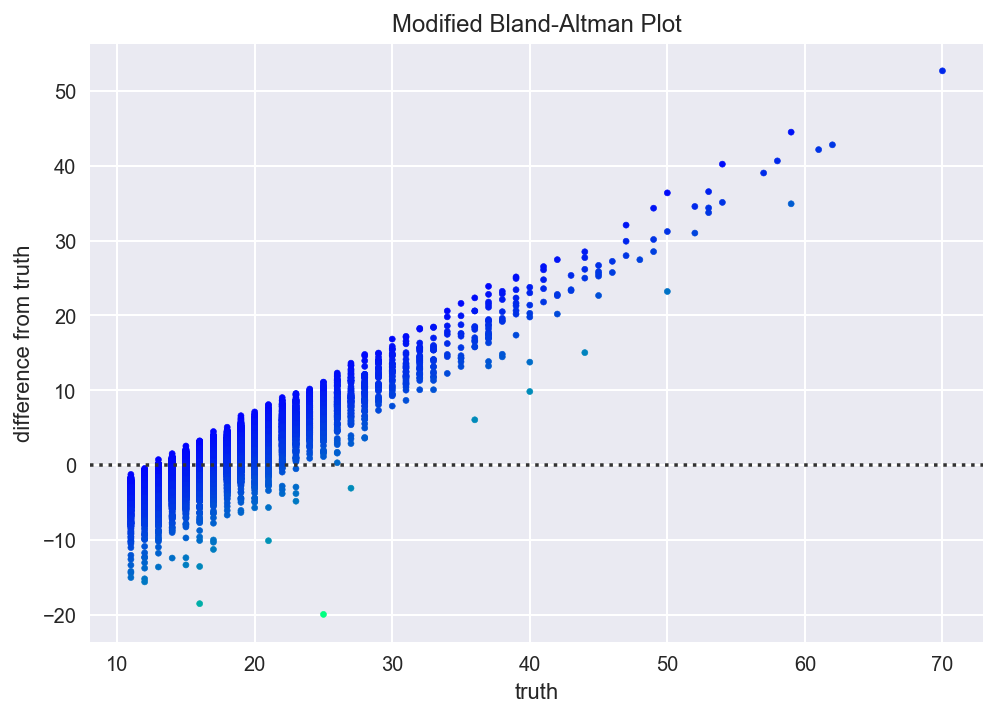

In [12]:
modified_bland_altman_plot(y_pred, y);

## Discussion
---

Our features are only the first ten temperatures of the cycle and the participant's last cycle length and follicular phase length. With it, we achieve a MSE of about 12, which beats the Bortot paper's 15. In terms of use case, this is about equal to the Bortot result.

In [13]:
df.L_PERIOD.median()

5.0

Now, the median period length is 5, which means that we are really using measurements of BBT during the period to determine the day of ovulation.

Since this model has only slight personalization, it's exciting to see how well a personalized model will do.